In [ ]:
import os
import math
import pickle
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from torch.utils.data import random_split
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

coh_base = '../data/COH/'
pli_base = '../data/PLI/'
ste_base = '../data/STE/'

BD_coh = load_pickle(os.path.join(coh_base, 'BD_coh_data.pkl'))
BD_pli = load_pickle(os.path.join(pli_base, 'BD_pli_data.pkl'))
MDD_coh = load_pickle(os.path.join(coh_base, 'MDD_coh_data.pkl'))
MDD_pli = load_pickle(os.path.join(pli_base, 'MDD_pli_data.pkl'))
BD_ste = load_pickle(os.path.join(ste_base, 'BD_ste_data.pkl'))
MDD_ste = load_pickle(os.path.join(ste_base, 'MDD_ste_data.pkl'))

frequency_bands = ['delta', 'theta', 'alpha', 'betalow', 'betahigh', 'gamma']


In [4]:
def vector_to_mat(vector, n=29):
    mat = np.zeros((n, n), dtype=vector.dtype)
    triu = np.triu_indices(n, k=1)
    mat[triu] = vector
    mat[(triu[1], triu[0])] = vector
    np.fill_diagonal(mat, 1)
    return mat


def build_subject_tensor(subj, coh_dict, pli_dict, ste_dict):
    mats = []
    for band in frequency_bands:
        mats.append(vector_to_mat(coh_dict[subj][band]))
    for band in frequency_bands:
        mats.append(vector_to_mat(pli_dict[subj][band]))
    for band in frequency_bands:
        m = ste_dict[subj][band].copy()
        np.fill_diagonal(m, 1)
        mats.append(m)
    # shape: (18, 29, 29)
    return np.stack(mats, axis=0)

In [5]:
BD_subjs = sorted(BD_coh.keys())
MDD_subjs = sorted(MDD_coh.keys())
all_subjs = BD_subjs + MDD_subjs
labels = [0]*len(BD_subjs) + [1]*len(MDD_subjs)

X_data = np.stack([build_subject_tensor(s, BD_coh, BD_pli, BD_ste) if i < len(BD_subjs) else build_subject_tensor(s, MDD_coh, MDD_pli, MDD_ste)
                   for i, s in enumerate(all_subjs)], axis=0)
# one-hot 條件向量
Y_data = np.eye(2)[labels]

# 轉為 TensorDataset
X_t = torch.tensor(X_data, dtype=torch.float32)
C_t = torch.tensor(Y_data, dtype=torch.float32)
vae_dataset = TensorDataset(X_t, C_t)
train_loader = DataLoader(vae_dataset, batch_size=16, shuffle=True)

In [50]:
class cVAE2d(nn.Module):
    def __init__(self, in_ch=18, latent_dim=10, num_classes=2, H=29, W=29):
        super().__init__()
        self.in_ch = in_ch
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.ds_h = math.ceil(H / 8)
        self.ds_w = math.ceil(W / 8)
        # Encoder
        self.enc_conv = nn.Sequential(
            nn.Conv2d(in_ch, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc_enc = nn.Sequential(
            nn.Linear(256 * self.ds_h * self.ds_w + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.fc_dec = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256 * self.ds_h * self.ds_w),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.dec_deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, in_ch, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def encode(self, x, c):
        h = self.enc_conv(x)                                # (B,256,ds_h,ds_w)
        h = h.view(h.size(0), -1)                           # (B,256*ds_h*ds_w)
        h = torch.cat([h, c], dim=1)                        # (B,*,+num_classes)
        h = self.fc_enc(h)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        zc = torch.cat([z, c], dim=1)
        h = self.fc_dec(zc)                                 # (B,256*ds_h*ds_w)
        h = h.view(-1, 256, self.ds_h, self.ds_w)           # (B,256,ds_h,ds_w)
        x_recon = self.dec_deconv(h)                        # (B,in_ch,>=H,>=W)
        return x_recon[:, :, :29, :29]

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

In [7]:
def loss_fn(recon,x,mu,logvar,beta=1.0):
    rec = F.mse_loss(recon,x,reduction='mean')*x.numel()/x.size(0)
    kl = -0.5*torch.mean(1+logvar-mu.pow(2)-logvar.exp())
    return rec+beta*kl, rec.item(), kl.item()

In [8]:
def train_vae(model,loader,epochs=100,lr=1e-3,beta=1.0,early_stop=False,patience=10):
    opt = optim.Adam(model.parameters(),lr=lr)
    best, no_imp = float('inf'),0
    hist = {'rec':[], 'kl':[]}
    for e in tqdm(range(1, epochs+1), desc='Training Epochs'):  # Epoch-level TQDM
        model.train()
        rec_sum = kl_sum = count = 0
        curr_beta = beta * (e / epochs)
        for x, c in loader:
            x, c = x.to(device), c.to(device)
            opt.zero_grad()
            recon, mu, logvar = model(x, c)
            loss, r, k = loss_fn(recon, x, mu, logvar, curr_beta)
            loss.backward()
            opt.step()
            b = x.size(0)
            rec_sum += r * b
            kl_sum += k * b
            count += b
        hist['rec'].append(rec_sum / count)
        hist['kl'].append(kl_sum / count)
        if early_stop:
            total_loss = hist['rec'][-1] + beta * hist['kl'][-1]
            if total_loss < best:
                best, no_imp = total_loss, 0
            else:
                no_imp += 1
                if no_imp >= patience:
                    print(f"Early stopping at epoch {e}")
                    break
    return model, hist

In [51]:
latent_dim = 100
beta = 1.0
epochs = 500
lr = 1e-3
vae = cVAE2d().to(device)
vae, history = train_vae(vae, train_loader, epochs, lr, beta, early_stop=True, patience=20)

Training Epochs:  56%|█████▌    | 281/500 [00:19<00:15, 14.59it/s]

Early stopping at epoch 282


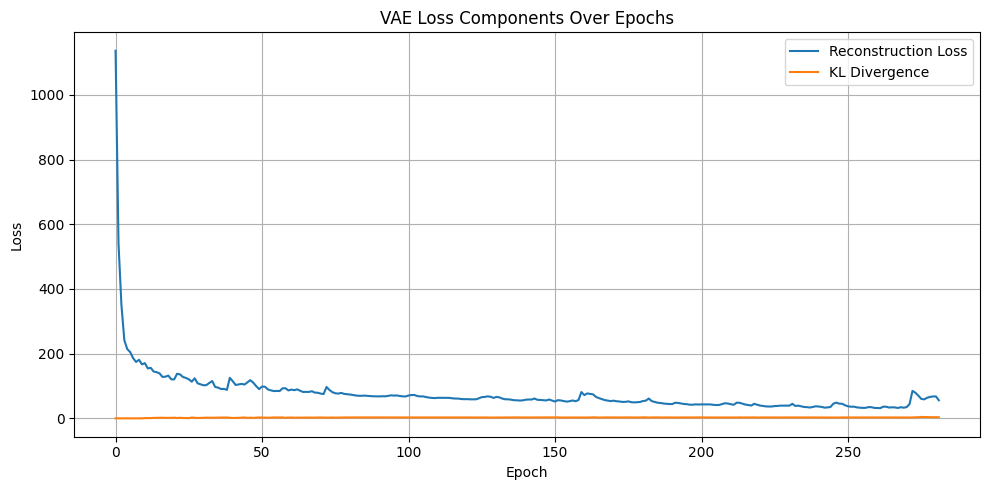

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(history['rec'], label='Reconstruction Loss')
plt.plot(history['kl'], label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Loss Components Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
class EEG_CNN(nn.Module):
    def __init__(self, in_ch=18, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, 64, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(512)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(512, 256)
        self.fc2   = nn.Linear(256, 128)
        self.fc3   = nn.Linear(128, 64)
        self.fc4   = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
def train_cnn(model, train_loader, val_loader=None, epochs=500, patience=50, lr=1e-5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    no_improve = 0
    best_state = None

    for epoch in tqdm(range(1, epochs+1), desc='CNN Epochs'):
        # Training
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)

        # Validation
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = model(xb)
                    loss = criterion(out, yb)
                    val_loss += loss.item() * xb.size(0)
            val_loss /= len(val_loader.dataset)
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                no_improve = 0
                best_state = model.state_dict()
            else:
                no_improve += 1
                if no_improve >= patience:
                    print(f"Early stopping CNN at epoch {epoch}")
                    break

    # Load best weights if available
    if best_state is not None:
        model.load_state_dict(best_state)

In [29]:
train_bd = BD_subjs[:45]
test_bd  = BD_subjs[45:]
train_mdd = MDD_subjs[:45]
test_mdd  = MDD_subjs[45:]

all_train = [(build_subject_tensor(s, BD_coh, BD_pli, BD_ste), 0) for s in train_bd] + \
            [(build_subject_tensor(s, MDD_coh, MDD_pli, MDD_ste), 1) for s in train_mdd]
all_test  = [(build_subject_tensor(s, BD_coh, BD_pli, BD_ste), 0) for s in test_bd] + \
            [(build_subject_tensor(s, MDD_coh, MDD_pli, MDD_ste), 1) for s in test_mdd]

X_train_np = np.stack([x for x, _ in all_train], axis=0)
y_train_np = np.array([y for _, y in all_train])
X_test_np  = np.stack([x for x, _ in all_test], axis=0)
y_test_np  = np.array([y for _, y in all_test])

# 測試集 tensors
X_test_t = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test_np, dtype=torch.long).to(device)


In [ ]:
def generate_samples(model, n_samples, cond):

    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, model.latent_dim, device=device)
        cond = cond.to(device)
        synth = model.decode(z, cond)
        return synth.cpu().numpy()
    model.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, latent_dim, device=device)
        cond = cond.to(device)
        synth = model.decode(z, cond)
        return synth.cpu().numpy()

In [23]:
epochs = 500
batch_size = 16

use_early_stopping = True
patience = 50   
 
use_loocv = True       
draw_loocv_cm = True 

In [53]:
gen_counts = list(range(10, 251, 10))
all_generated = {}
results = []


rs = gen_counts  
all_generated = {}
results = []

for r in rs:
    best_acc = -np.inf
    best_synth0 = None
    best_synth1 = None


    for trial in range(2):
    
        cond0 = torch.zeros(r, vae.num_classes, device=device); cond0[:,0]=1
        cond1 = torch.zeros(r, vae.num_classes, device=device); cond1[:,1]=1

        synth0_c = generate_samples(vae, r, cond0)
        synth1_c = generate_samples(vae, r, cond1)
    
        X_aug = np.concatenate([X_train_np, synth0_c, synth1_c], axis=0)
        y_aug = np.concatenate([y_train_np, np.zeros(r), np.ones(r)], axis=0)

        aug_ds = TensorDataset(
            torch.tensor(X_aug, dtype=torch.float32),
            torch.tensor(y_aug, dtype=torch.long)
        )
        n_tr = int(0.85 * len(aug_ds)); n_val = len(aug_ds) - n_tr
        tr_ds, val_ds = random_split(aug_ds, [n_tr, n_val])
        tr_loader = DataLoader(tr_ds, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=16)

        cnn = EEG_CNN().to(device)
        train_cnn(cnn, tr_loader, val_loader, epochs=500, patience=50)
        cnn.eval()
 
        with torch.no_grad():
            preds = torch.argmax(cnn(X_test_t), dim=1).cpu().numpy()
        acc = accuracy_score(y_test_np, preds)
  
        if acc > best_acc:
            best_acc = acc
            best_synth0 = synth0_c
            best_synth1 = synth1_c


    all_generated[r] = {'synth0': best_synth0, 'synth1': best_synth1}
    results.append(best_acc)
    print(f"r={r:3d} | Best Test Accuracy: {best_acc:.4f}")

CNN Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

CNN Epochs:  19%|█▉        | 96/500 [00:04<00:18, 22.02it/s]


Early stopping CNN at epoch 97


CNN Epochs:  26%|██▌       | 129/500 [00:05<00:16, 22.82it/s]


Early stopping CNN at epoch 130
r= 10 | Best Test Accuracy: 0.7949


CNN Epochs:  32%|███▏      | 160/500 [00:07<00:16, 20.44it/s]


Early stopping CNN at epoch 161


CNN Epochs:  30%|███       | 152/500 [00:07<00:16, 20.49it/s]


Early stopping CNN at epoch 153
r= 20 | Best Test Accuracy: 0.8462


CNN Epochs:  21%|██        | 103/500 [00:05<00:22, 17.87it/s]


Early stopping CNN at epoch 104


CNN Epochs:  33%|███▎      | 163/500 [00:08<00:18, 18.11it/s]


Early stopping CNN at epoch 164
r= 30 | Best Test Accuracy: 0.8205


CNN Epochs:  22%|██▏       | 112/500 [00:06<00:24, 16.12it/s]


Early stopping CNN at epoch 113


CNN Epochs:  33%|███▎      | 165/500 [00:10<00:20, 16.29it/s]


Early stopping CNN at epoch 166
r= 40 | Best Test Accuracy: 0.8205


CNN Epochs:  33%|███▎      | 167/500 [00:12<00:24, 13.70it/s]


Early stopping CNN at epoch 168


CNN Epochs:  39%|███▊      | 193/500 [00:14<00:22, 13.59it/s]


Early stopping CNN at epoch 194
r= 50 | Best Test Accuracy: 0.8205


CNN Epochs:  32%|███▏      | 160/500 [00:12<00:26, 12.60it/s]


Early stopping CNN at epoch 161


CNN Epochs:  44%|████▍     | 219/500 [00:17<00:22, 12.67it/s]


Early stopping CNN at epoch 220
r= 60 | Best Test Accuracy: 0.8205


CNN Epochs:  55%|█████▍    | 273/500 [00:23<00:19, 11.51it/s]


Early stopping CNN at epoch 274


CNN Epochs:  23%|██▎       | 114/500 [00:09<00:33, 11.44it/s]


Early stopping CNN at epoch 115
r= 70 | Best Test Accuracy: 0.7949


CNN Epochs:  29%|██▉       | 146/500 [00:13<00:33, 10.69it/s]


Early stopping CNN at epoch 147


CNN Epochs:  29%|██▊       | 143/500 [00:13<00:33, 10.70it/s]


Early stopping CNN at epoch 144
r= 80 | Best Test Accuracy: 0.8205


CNN Epochs:  20%|█▉        | 99/500 [00:09<00:40,  9.98it/s]


Early stopping CNN at epoch 100


CNN Epochs:  33%|███▎      | 167/500 [00:16<00:33, 10.04it/s]


Early stopping CNN at epoch 168
r= 90 | Best Test Accuracy: 0.8205


CNN Epochs:  22%|██▏       | 108/500 [00:11<00:41,  9.38it/s]


Early stopping CNN at epoch 109


CNN Epochs:  21%|██        | 104/500 [00:11<00:42,  9.26it/s]


Early stopping CNN at epoch 105
r=100 | Best Test Accuracy: 0.8205


CNN Epochs:  46%|████▋     | 232/500 [00:26<00:30,  8.80it/s]


Early stopping CNN at epoch 233


CNN Epochs:  33%|███▎      | 166/500 [00:19<00:39,  8.56it/s]


Early stopping CNN at epoch 167
r=110 | Best Test Accuracy: 0.8205


CNN Epochs:  23%|██▎       | 117/500 [00:14<00:48,  7.90it/s]


Early stopping CNN at epoch 118


CNN Epochs:  25%|██▌       | 125/500 [00:16<00:48,  7.74it/s]


Early stopping CNN at epoch 126
r=120 | Best Test Accuracy: 0.8205


CNN Epochs:  27%|██▋       | 135/500 [00:18<00:48,  7.50it/s]


Early stopping CNN at epoch 136


CNN Epochs:  39%|███▉      | 194/500 [00:25<00:40,  7.60it/s]


Early stopping CNN at epoch 195
r=130 | Best Test Accuracy: 0.7949


CNN Epochs:  42%|████▏     | 208/500 [00:28<00:40,  7.23it/s]


Early stopping CNN at epoch 209


CNN Epochs:  28%|██▊       | 140/500 [00:19<00:49,  7.24it/s]


Early stopping CNN at epoch 141
r=140 | Best Test Accuracy: 0.8205


CNN Epochs:  20%|█▉        | 99/500 [00:14<00:58,  6.84it/s]


Early stopping CNN at epoch 100


CNN Epochs:  18%|█▊        | 92/500 [00:13<01:00,  6.78it/s]


Early stopping CNN at epoch 93
r=150 | Best Test Accuracy: 0.7949


CNN Epochs:  35%|███▌      | 177/500 [00:26<00:49,  6.56it/s]


Early stopping CNN at epoch 178


CNN Epochs:  30%|███       | 150/500 [00:22<00:53,  6.55it/s]


Early stopping CNN at epoch 151
r=160 | Best Test Accuracy: 0.8462


CNN Epochs:  20%|██        | 101/500 [00:16<01:04,  6.18it/s]


Early stopping CNN at epoch 102


CNN Epochs:  33%|███▎      | 167/500 [00:26<00:53,  6.23it/s]


Early stopping CNN at epoch 168
r=170 | Best Test Accuracy: 0.8462


CNN Epochs:  52%|█████▏    | 261/500 [00:43<00:39,  6.01it/s]


Early stopping CNN at epoch 262


CNN Epochs:  15%|█▌        | 76/500 [00:12<01:11,  5.95it/s]


Early stopping CNN at epoch 77
r=180 | Best Test Accuracy: 0.8205


CNN Epochs:  36%|███▌      | 181/500 [00:30<00:53,  5.93it/s]


Early stopping CNN at epoch 182


CNN Epochs:  29%|██▉       | 146/500 [00:24<01:00,  5.90it/s]


Early stopping CNN at epoch 147
r=190 | Best Test Accuracy: 0.7949


CNN Epochs:  23%|██▎       | 117/500 [00:19<01:05,  5.86it/s]


Early stopping CNN at epoch 118


CNN Epochs:  52%|█████▏    | 259/500 [00:43<00:40,  6.00it/s]


Early stopping CNN at epoch 260
r=200 | Best Test Accuracy: 0.8462


CNN Epochs:  20%|█▉        | 99/500 [00:17<01:11,  5.61it/s]


Early stopping CNN at epoch 100


CNN Epochs:  40%|███▉      | 198/500 [00:35<00:53,  5.65it/s]


Early stopping CNN at epoch 199
r=210 | Best Test Accuracy: 0.8205


CNN Epochs:  27%|██▋       | 136/500 [00:25<01:07,  5.39it/s]


Early stopping CNN at epoch 137


CNN Epochs:  16%|█▌        | 81/500 [00:15<01:18,  5.34it/s]


Early stopping CNN at epoch 82
r=220 | Best Test Accuracy: 0.8462


CNN Epochs:  50%|█████     | 251/500 [00:48<00:48,  5.18it/s]


Early stopping CNN at epoch 252


CNN Epochs:  19%|█▊        | 93/500 [00:18<01:19,  5.13it/s]


Early stopping CNN at epoch 94
r=230 | Best Test Accuracy: 0.8718


CNN Epochs:  32%|███▏      | 160/500 [00:31<01:07,  5.00it/s]


Early stopping CNN at epoch 161


CNN Epochs:  43%|████▎     | 216/500 [00:43<00:56,  4.99it/s]


Early stopping CNN at epoch 217
r=240 | Best Test Accuracy: 0.8205


CNN Epochs:  16%|█▌        | 81/500 [00:17<01:30,  4.62it/s]


Early stopping CNN at epoch 82


CNN Epochs:  48%|████▊     | 242/500 [00:50<00:53,  4.81it/s]

Early stopping CNN at epoch 243
r=250 | Best Test Accuracy: 0.8718


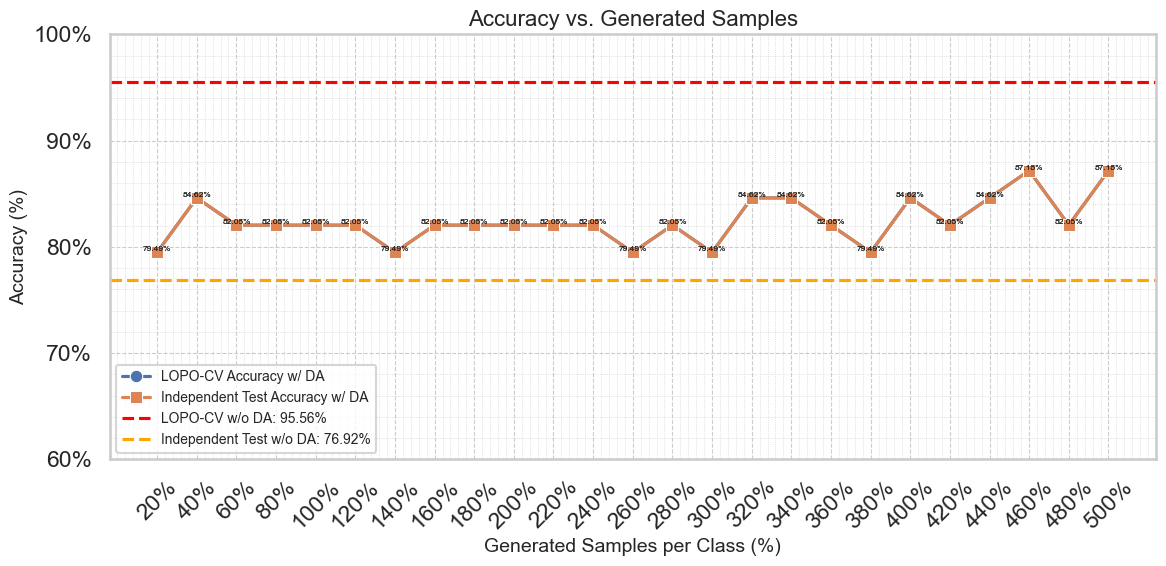

In [ ]:
loocv_scores = results  # LOOCV scores
test_scores  = results


loocv_pct = [s * 100 for s in loocv_scores]
test_pct  = [s * 100 for s in test_scores]

# y axis limits
min_val = min(loocv_pct + test_pct)
lower = int(np.floor((min_val - 10) / 10)) * 10
lower = max(lower, 0)
max_val = max(loocv_pct + test_pct)
upper = min(max_val + 2, 102)



sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(12, 6))

# LOPO-CV 
sns.lineplot(x=rs, y=loocv_pct, marker="o",
             label="LOPO-CV Accuracy w/ DA", ax=ax, clip_on=False)
# Independent Test
sns.lineplot(x=rs, y=test_pct, marker="s",
             label="Independent Test Accuracy w/ DA", ax=ax, clip_on=False)



# values
for x, y in zip(rs, loocv_pct):
    ax.text(x, y, f"{y:.2f}%", va='bottom', ha='center', fontsize=6, clip_on=False)
for x, y in zip(rs, test_pct):
    ax.text(x, y, f"{y:.2f}%", va='bottom', ha='center', fontsize=6, clip_on=False)

# baseline
baseline1 = 95.56
baseline2 = 76.92
ax.axhline(baseline1, linestyle='--', color='red', label=f"LOPO-CV w/o DA: {baseline1}%", clip_on=False)
ax.axhline(baseline2, linestyle='--', color='orange', label=f"Independent Test w/o DA: {baseline2}%", clip_on=False)



# X axis ticks
ax.set_xticks(rs)
ax.set_xticklabels([f"{x*2}%" for x in rs], rotation=45)

# Y axis ticks
ax.set_ylim(lower, upper)
yticks = list(range(lower, 101, 10))
ax.set_yticks(yticks)
ax.set_yticklabels([f"{y}%" for y in yticks])



ax.set_xlabel("Generated Samples per Class (%)", fontsize=14)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_title("Accuracy vs. Generated Samples", fontsize=16)
ax.minorticks_on()
ax.grid(which="major", linestyle="--", linewidth=0.8)
ax.grid(which="minor", linestyle=":", linewidth=0.5)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()


##### plot t-sne & confusion matrix 

CNN Epochs:  17%|█▋        | 84/500 [00:17<01:27,  4.77it/s]

Early stopping CNN at epoch 85


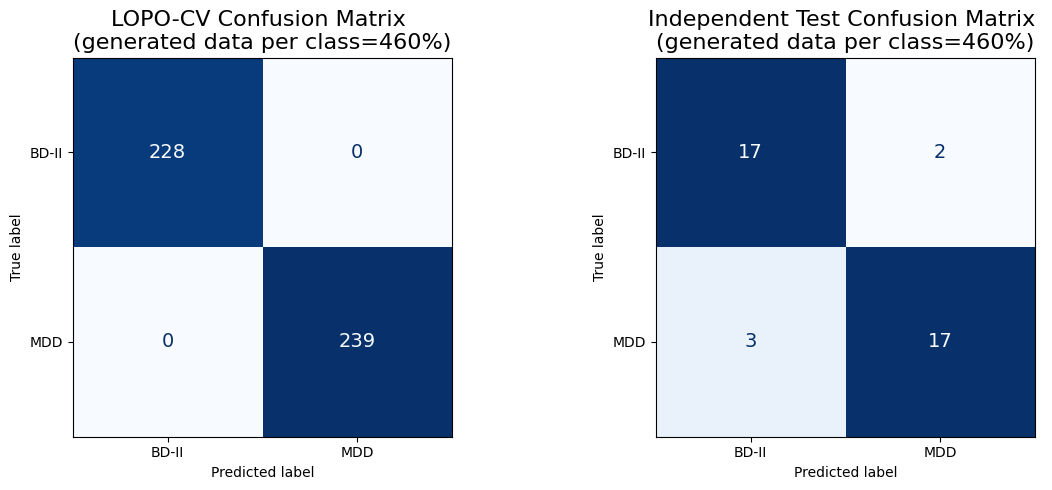

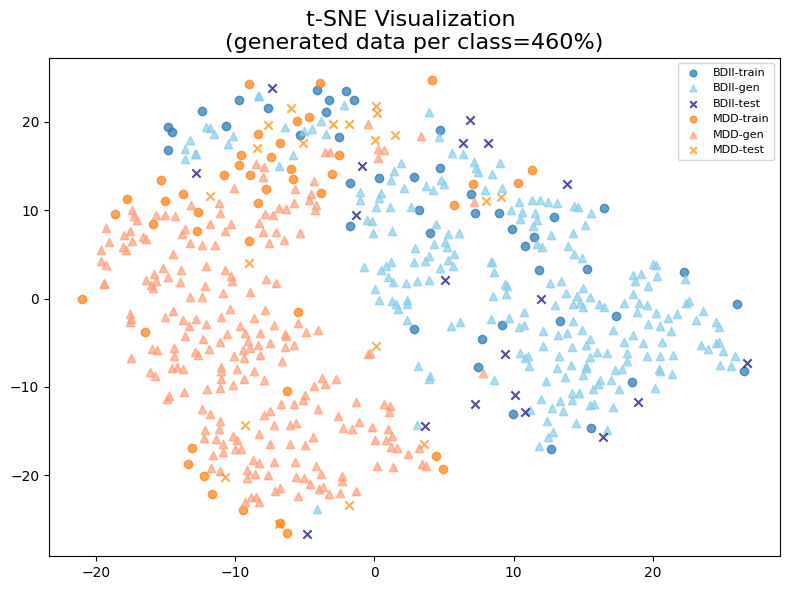

In [ ]:
sns.reset_defaults()
best_r = rs[int(np.argmax(results))]


def plot_combined_confusion_cnn(r):
    synth0 = all_generated[r]['synth0']
    synth1 = all_generated[r]['synth1']
    
    X_aug = np.concatenate([X_train_np, synth0, synth1], axis=0)
    y_aug = np.concatenate([y_train_np, np.zeros(r), np.ones(r)], axis=0)
    
    aug_ds = TensorDataset(
        torch.tensor(X_aug, dtype=torch.float32),
        torch.tensor(y_aug, dtype=torch.long)
    )
    n_tr = int(0.85 * len(aug_ds)); n_val = len(aug_ds) - n_tr
    tr_ds, val_ds = random_split(aug_ds, [n_tr, n_val])
    tr_loader = DataLoader(tr_ds, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=16)

    # train CNN
    cnn = EEG_CNN().to(device)
    train_cnn(cnn, tr_loader, val_loader, epochs=500, patience=50)

    # LOPO-CV confusion matrix
    y_true, y_pred = [], []
    for x, y in tr_ds:
        out = cnn(x.unsqueeze(0).to(device))
        y_true.append(int(y.item()))
        y_pred.append(int(torch.argmax(out, dim=1).item()))
    cm_loocv = confusion_matrix(y_true, y_pred)

    # Independent test confusion matrix
    cnn.eval()
    with torch.no_grad():
        out = cnn(X_test_t)
        y_pred_test = torch.argmax(out, dim=1).cpu().numpy()
    cm_test = confusion_matrix(y_test_np, y_pred_test)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    disp_loocv = ConfusionMatrixDisplay(cm_loocv, display_labels=["BD-II","MDD"] )
    disp_loocv.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False, text_kw={'fontsize':14})
    axes[0].set_title(f"LOPO-CV Confusion Matrix \n(generated data per class={r*2}%)", fontsize=16)

    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=["BD-II","MDD"] )
    disp_test.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False, text_kw={'fontsize':14})
    axes[1].set_title(f"Independent Test Confusion Matrix \n(generated data per class={r*2}%)", fontsize=16)

    plt.tight_layout(); plt.show()





def plot_tsne_cnn(r):
    synth0 = all_generated[r]['synth0']
    synth1 = all_generated[r]['synth1']
    X_vis = np.vstack([X_train_np, synth0, synth1, X_test_np])
    y_vis = np.concatenate([y_train_np, np.zeros(r), np.ones(r), y_test_np])
    types = (['train']*len(X_train_np) + ['gen']*(2*r) + ['test']*len(X_test_np))

    tsne = TSNE(n_components=2, random_state=43)
    feats = X_vis.reshape(X_vis.shape[0], -1)
    emb = tsne.fit_transform(feats)

    color_map = {(0,'train'):'tab:blue',(0,'gen'):'skyblue',(0,'test'):'navy',
                 (1,'train'):'tab:orange',(1,'gen'):'lightsalmon',(1,'test'):'darkorange'}
    marker_map = {'train':'o','gen':'^','test':'x'}

    fig, ax = plt.subplots(figsize=(8,6))
    for cls in [0,1]:
        for t in ['train','gen','test']:
            idx = np.where((y_vis==cls) & (np.array(types)==t))
            ax.scatter(emb[idx,0], emb[idx,1],
                       label=f"{['BDII','MDD'][cls]}-{t}",
                       marker=marker_map[t], color=color_map[(cls,t)], alpha=0.7)
    ax.legend(fontsize=8, markerscale=0.8)
    ax.set_title(f"t-SNE Visualization \n(generated data per class={r*2}%)", fontsize=16)
    plt.tight_layout(); plt.show()




# Plot confusion matrix and t-SNE for the best r
plot_combined_confusion_cnn(best_r)
plot_tsne_cnn(best_r)


In [58]:
### save all generated data
with open('../result_DL/BD_MDD/w_DA/all_generated_samples.pkl', 'wb') as f:
    pickle.dump(all_generated, f)


### save model
vae_best_model = vae.state_dict()
with open("../result_DL/BD_MDD/w_DA/vae_model.pt", "wb") as f:
    torch.save(vae_best_model, f)

